In [ ]:
# !git clone https://github.com/Jimmy-Nnilsson/StudieGrupp3_MLProjekt.git

In [ ]:
# !pip install wandb

In [ ]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
print("TF: ", tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import models
from keras import Model
import keras

from pathlib import Path
from keras.preprocessing.image import load_img, img_to_array, image_dataset_from_directory
from tensorflow.keras.applications import vgg16, vgg19

import wandb
from wandb.keras import WandbCallback

import cv2

TF:  2.7.0


In [ ]:
# wandb.login()

In [ ]:
def seed_everything():
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
    np.random.seed(hash("improves reproducibility") % 2**32 - 1)
    tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

seed_everything()

In [ ]:

# Get base project directory
project_path = Path(os.getcwd()).parent.parent
# project_path = Path('/content/StudieGrupp3_MLProjekt/')
datapath = (project_path /'data/processed/')

CLASSES = {0 : 'yes', 1 : 'no'}
# Loops through pathlist and reads and resizes images
def read_image(pathlist : list, size : int)-> list:
    data = []
    for path in pathlist:
        image=load_img(path, color_mode='rgb', target_size=(size, size))
        image=img_to_array(image)
        # image=image/255.0
        data.append(image)
    data = np.asarray(data, dtype=np.uint8)
    return data

# Makes input and label data from folder locations.
# Loops through location "subfolder/CLASSES"
def get_sets(subfolder : str, CLASSES : dict, size : int):
    folder_paths = []
    folder_labels = []
    labels = []
    for k,v in CLASSES.items():
        # input datapath generation
        folder_paths += list((datapath / f"2_split_{v}/{subfolder}").rglob("*"))
    # Label data generation
    folder_labels = [0 if x.stem.split('_')[1] == 'yes' else 1 for x in folder_paths]
    folder_labels = np.asarray(folder_labels, dtype=np.uint8)
    # Extract images from datapaths
    img_list = read_image(folder_paths, size)

    return img_list, folder_labels

def get_training_set(CLASSES : dict, size : int):
    folder_paths = []
    folder_labels = []
    labels = []
    for k,v in CLASSES.items():
        # input datapath generation
        folder_paths += list((datapath / f"3_aug_{v}_train/").rglob("*"))
        # print(folder_paths)
    # Label data generation
    folder_labels = [0 if x.stem.split('_')[1] == 'yes' else 1 for x in folder_paths]
    # Extract images from datapaths
    img_list = read_image(folder_paths, size)

    return img_list, folder_labels

Load Pictures

In [ ]:
# Dataset inspect
# Read images to variables
size = 224
X_aug_train, y_aug_train = get_training_set(CLASSES, size)
X_train, y_train = get_sets('train', CLASSES, size)
X_val, y_val = get_sets('val', CLASSES, size)
X_test, y_test = get_sets('test', CLASSES, size)

Data loader

In [ ]:
#@title
@tf.function
def preprocess(image: tf.Tensor, label: tf.Tensor):
    """
    Preprocess the image tensors and parse the labels
    """
    # Preprocess images
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Parse label
    label = tf.cast(label, tf.float32)

    return image, label


def prepare_dataloader(images: np.ndarray,
                       labels: np.ndarray,
                       loader_type: str='train',
                       batch_size: int=128):
    """
    Utility function to prepare dataloader.
    """
    images = vgg19.preprocess_input(images)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if loader_type=='train':
        dataset = dataset.shuffle(1024)

    dataloader = (
        dataset
        .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    return dataloader

Config parameters

In [ ]:
configs = dict(
    mode = 'run', #{'offline', 'run', 'disabled', 'dryrun', 'online'}
    image_width = X_train[0].shape[0],
    image_height = X_train[0].shape[1],
    image_channels = X_train[0].shape[2],
    batch_size = 4,
    class_names = CLASSES,
    model_name = '', # set after model is defined
    pretrain_weights = 'imagenet',
    epochs = 5,
    init_learning_rate = 0.001,
    lr_decay_rate = 0.1,
    optimizer = 'adam',
    loss_fn = 'binary_crossentropy',
    metrics = ['accuracy'],
    earlystopping_patience = 5,
    architecture = "",# To be defined f"{base_model._name.upper()} global_average_pooling2d",
    dataset = "Brain_MRI_Images_for_Brain_Tumor_Detection"
)

In [ ]:
trainloader = prepare_dataloader(X_train, y_train, 'train', configs.get('batch_size', 64))
augtrainloader = prepare_dataloader(X_aug_train, y_aug_train, 'train', configs.get('batch_size', 64))
validloader = prepare_dataloader(X_val, y_val, 'valid', configs.get('batch_size', 64))
testloader = prepare_dataloader(X_test, y_test, 'test', configs.get('batch_size', 64))

Model Callbacks

In [ ]:
checkpoint_filepath = (Path(os.getcwd()) /'model_checkpoint/model_checkpoint')

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
earlystopper = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=configs['earlystopping_patience'], verbose=0, mode='auto',
    restore_best_weights=True
)

In [ ]:
def lr_scheduler(epoch, lr):
    # log the current learning rate onto W&B
    if wandb.run is None:
        raise wandb.Error("You must call wandb.init() before WandbCallback()")

    wandb.log({'learning_rate': lr}, commit=False)

    if epoch < 7:
        return lr
    else:
        return lr * tf.math.exp(-configs['lr_decay_rate'])

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

Model class definition

In [ ]:
class Model_Class():
    def __init__(self,
                 output_activation: str='sigmoid'
                 ):

        self.shape = (configs['image_width'],configs['image_height'], configs['image_channels'])
        self.model = ""
        self.output_activation = output_activation
        self.run = ""
        self.__get_model()
        self.conv_layers, self.layer_names = self.__get_convlayers()
        self.preds = ""
        if not wandb.run is None: wandb.finish()

    def __get_model(self):
        kwarg = dict(weights=configs['pretrain_weights'], include_top=False, input_shape=self.shape)
        base_model = vgg19.VGG19(**kwarg)
        base_model.trainable = False

        x = layers.GlobalAveragePooling2D()(base_model.output)

        outputs = layers.Dense(1, activation=self.output_activation)(x)
        configs['architecture'] = base_model._name
        self.model  = models.Model(base_model.input, outputs, name=f'Baseline_{base_model._name.upper()}')

    def train(self,
        callbacks: list,
        verbose: int=0,
        wb: bool=False):

        if wb:
            callbacks.append(self._wandb())

        # Initalize model
        tf.keras.backend.clear_session()
        configs['model_name'] = self.model._name # set

        # Compile the model
        opt = tf.keras.optimizers.Adam(learning_rate=configs['init_learning_rate'])
        self.model.compile(optimizer=opt,
                    loss=configs['loss_fn'],
                    metrics=configs['metrics'])

        _ = self.model.fit(trainloader,
                    epochs=configs['epochs'],
                    validation_data=validloader,
                    callbacks=callbacks,
                    verbose=verbose)
        if wb:
            # Evaluate the trained model
            loss, acc = self.model.evaluate(validloader)
            wandb.log({'evaluate/accuracy': acc})

            # Close the W&B run.
            wandb.finish()

    def grad_cam(self, image, layer=None):
        self.preds = self.predict(image)
        if type(layer) is list:
            heatmap_list, superimposed_list = {},{}
            for layer_num in layer:
                heatmap = self.make_gradcam_heatmap(np.expand_dims(image, axis=0), layer_num, np.argmax(self.preds[0]))
                superimposed_img = self.superimpose(image,heatmap)
                heatmap_list[self.model.layers[layer_num]._name] = heatmap
                superimposed_list[self.model.layers[layer_num]._name] = superimposed_img
            return image, heatmap_list, superimposed_list
        else:
            heatmap = self.make_gradcam_heatmap(np.expand_dims(image, axis=0), layer, np.argmax(self.preds[0]))
            superimposed_img = self.superimpose(image,heatmap)
            return image, heatmap, superimposed_img


    def make_gradcam_heatmap(self, img_array, layer=None, pred_index=None):
        # First, we create a model that maps the input image to the activations
        # of the last conv layer as well as the output predictions
        if layer == None: layer=self.conv_layers[-1]
        model = self.model
        grad_model = Model(
            [model.inputs], [model.layers[layer].output, model.output]
            # [model.inputs], [model.get_layer(self.layer_names[-1]).output, model.output]
        )

        # Then, we compute the gradient of the top predicted class for our input image
        # with respect to the activations of the last conv layer
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        # This is the gradient of the output neuron (top predicted or chosen)
        # with regard to the output feature map of the last conv layer
        grads = tape.gradient(class_channel, last_conv_layer_output)

        # This is a vector where each entry is the mean intensity of the gradient
        # over a specific feature map channel
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # We multiply each channel in the feature map array
        # by "how important this channel is" with regard to the top predicted class
        # then sum all the channels to obtain the heatmap class activation
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

    def predict(self, pic):
        x_pre = vgg19.preprocess_input(pic)
        x = np.expand_dims(x_pre, axis=0)

        preds = self.model.predict(x)
        return preds

    def superimpose(self, pic,heatmap):
        img_numpy = np.asarray(pic)

        heatmap_resized = cv2.resize(heatmap, (img_numpy.shape[1], img_numpy.shape[0]))
        heatmap_resized = np.uint8(255 * heatmap_resized)
        heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

        superimposed_img = 0.3*heatmap_resized[:,:,::-1] + img_numpy
        superimposed_img = superimposed_img.astype(np.uint8)
        return superimposed_img

    def __get_convlayers(self):
        list_conv_layers = []
        list_layer_names = []
        for i,l in enumerate(self.model.layers):
            # print(str(l).split('.'))
            if str(l).split('.')[2] == 'convolutional':
                list_conv_layers.append(i)
                list_layer_names.append(l._name)
        return list_conv_layers, list_layer_names

    def __wandb(self): 
        self.run = wandb.init(mode=configs['mode'] ,project='test_wandb', config=configs, job_type='Baseline')

        # Define WandbCallback for experiment tracking
        wandb_callback = WandbCallback(monitor='val_loss',
                                    log_weights=True,
                                    log_evaluation=True,
                                    validation_steps=5,
                                    save_model=True,
                                    save_graph = True
                                    )
        return wandb_callback

    def set_trainable(self): # Sets whole model to trainable
        self.model.trainable = True

    def freeze_layers(self, freeze_exclude=None):
        if type(freeze_exclude) == None:
            self.model.trainable = False
        elif type(freeze_exclude) == int:
            if freeze_exclude != 0:
                nlayers = len(model.model.layers)
                [l for l in range(nlayers-1,nlayers-freeze_exclude,-1)]
            else:
                self.model.trainable == True
        elif type(freeze_exclude) == list:
            pass

Call model

In [ ]:
model = Model_Class()

In [ ]:
exclude = 2
for l in range(len(model.model.layers)):
    print(l)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [ ]:
[l for l in range(len(model.model.layers)-1,-1,-1)]


[23,
 22,
 21,
 20,
 19,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0]

Make gradcams

In [ ]:
model.conv_layers

[1, 2, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20]

In [ ]:
image, heatmap, superimposed_img = model.grad_cam(X_train[0], model.conv_layers)

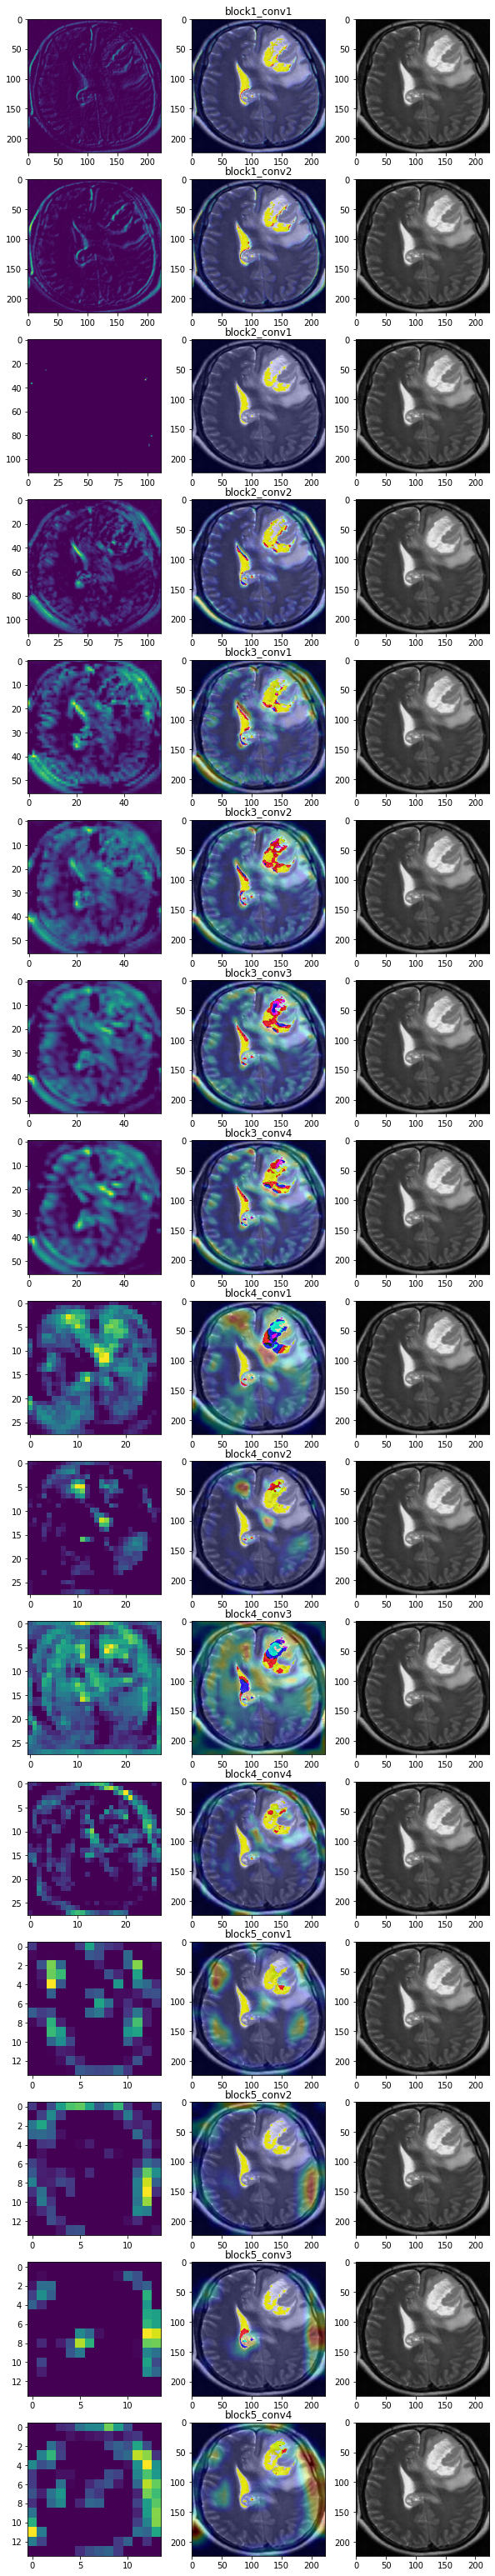

In [ ]:
if type(heatmap) == dict and type(superimposed_img) == dict:
    nlen = len(heatmap)
    fig, ax = plt.subplots(nlen,3, figsize=(10, nlen*3.5))
    # fig.figsize=(20,20)
    for i, (k, img) in enumerate(heatmap.items()):
        ax[i,0].imshow(img)
        ax[i,1].set_title(k)
        ax[i,1].imshow(superimposed_img[k])
        ax[i,2].imshow(image)

Plot gradcams

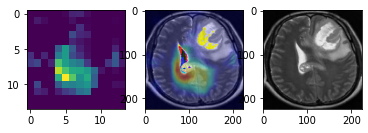

In [ ]:


plt.subplot(1,3, 1)
plt.imshow(heatmap)
plt.subplot(1,3, 2)
plt.imshow(superimposed_img)
plt.subplot(1,3, 3)
plt.imshow(image)

Train without wandb

In [ ]:

# WandbCallback(data_type='image', training_data=(np.array(X_val),np.array(y_val)), labels=CLASSES, save_model=True, save_graph=True)
# callbacks
callbacks = [earlystopper]

# Train
model.train(callbacks=callbacks, verbose=2, wb=False)



Train with wandb

In [ ]:
# WandbCallback(data_type='image', training_data=(np.array(X_val),np.array(y_val)), labels=CLASSES, save_model=True, save_graph=True)
# callbacks
callbacks = [earlystopper]

# Train
model.train(callbacks=callbacks, verbose=2, wb=True)
